<a href="https://colab.research.google.com/github/toliyang/AI_ML/blob/main/ML%20foundation/gradient_descent_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Descent from Scratch

This notebook is similar to the [*Batch Regression Gradient* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/batch-regression-gradient.ipynb) with the critical exception that we optimize via gradient descent without relying on the built-in PyTorch `SGD()` optimizer.

In [25]:
import torch
import matplotlib.pyplot as plt

In [26]:
xs = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.])
ys = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37])

In [27]:
def regression(my_x, my_m, my_b):
    return my_m*my_x + my_b

In [28]:
# m and b are positive
m = torch.tensor([0.9]).requires_grad_()
b = torch.tensor([0.1]).requires_grad_()
# m is negative
# m = torch.tensor([-0.9]).requires_grad_()
# b = torch.tensor([0.1]).requires_grad_()

**Step 1**: Forward pass

In [29]:
yhats = regression(xs, m, b)
yhats

tensor([ 0.1000, -0.8000, -1.7000, -2.6000, -3.5000, -4.4000, -5.3000, -6.2000],
       grad_fn=<AddBackward0>)

**Step 2**: Compare $\hat{y}$ with true $y$ to calculate cost $C$

Mean squared error: $$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $$

In [30]:
def mse(my_yhat, my_y):
    sigma = torch.sum((my_yhat - my_y)**2)
    return sigma/len(my_y)

In [31]:
C = mse(yhats, ys)
C

tensor(11.0265, grad_fn=<DivBackward0>)

**Step 3**: Use autodiff to calculate gradient of $C$ w.r.t. parameters

In [32]:
C.backward()

In [33]:
m.grad

tensor([-26.6950])

$\frac{\partial C}{\partial m} = 36.3$ indicates that an increase in $m$ corresponds to a large increase in $C$.

In [34]:
b.grad

tensor([-6.3350])

Meanwhile, $\frac{\partial C}{\partial b} = 6.26$ indicates that an increase in $b$ also corresponds to an increase in $C$, though much less so than $m$.

(Using partial derivatives derived in [*Calculus II*](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/4-calculus-ii.ipynb), we could alternatively calculate these same slopes without automatic numerical computation:)

$$ \frac{\partial C}{\partial m} = \frac{2}{n} \sum (\hat{y}_i - y_i) \cdot x_i $$

In [35]:
2*1/len(ys)*torch.sum((yhats - ys)*xs)

tensor(-26.6950, grad_fn=<MulBackward0>)

$$ \frac{\partial C}{\partial b} = \frac{2}{n} \sum (\hat{y}_i - y_i) $$

In [36]:
2*1/len(ys)*torch.sum(yhats - ys)

tensor(-6.3350, grad_fn=<MulBackward0>)

The gradient of cost, $\nabla C$, is:

In [37]:
gradient = torch.tensor([[b.grad.item(), m.grad.item()]]).T
gradient

tensor([[ -6.3350],
        [-26.6950]])

For convenience, model parameters are often denoted as $\boldsymbol{\theta}$, which, depending on the model, could be, for example, a vector, a matrix, or a collection of tensors of varying dimensions. With our simple linear model, a vector tensor will do:

In [38]:
theta = torch.tensor([[b, m]]).T
theta

tensor([[ 0.1000],
        [-0.9000]])

Note the gradient $\nabla C$ could thus alternatively be denoted with respect to  $\boldsymbol{\theta}$ as $\nabla_\boldsymbol{\theta} f(\boldsymbol{\theta})$.

(Also, note that we're transposing $\boldsymbol{\theta}$ to make forthcoming tensor operations easier because of the convention in ML to transpose the gradient, $\nabla C$.)

Let's visualize the state of the most pertinent metrics in a single plot:

In [41]:
def labeled_regression_plot(my_x, my_y, my_m, my_b, my_C, include_grad=True):

    title = 'Cost = {}'.format('%.3g' % my_C.item())
    if include_grad:
        xlabel = 'm = {}, m grad = {}'.format('%.3g' % my_m.item(), '%.3g' % my_m.grad.item())
        ylabel = 'b = {}, b grad = {}'.format('%.3g' % my_b.item(), '%.3g' % my_b.grad.item())
    else:
        xlabel = 'm = {}'.format('%.3g' % my_m.item())
        ylabel = 'b = {}'.format('%.3g' % my_b.item())

    fig, ax = plt.subplots()

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

    ax.scatter(my_x, my_y)

    x_min, x_max = ax.get_xlim()
    y_min = regression(x_min, my_m, my_b).detach().numpy()
    y_max = regression(x_max, my_m, my_b).detach().numpy()

    ax.set_xlim([x_min, x_max])
    _ = ax.plot([x_min, x_max], [y_min, y_max], c='C01')

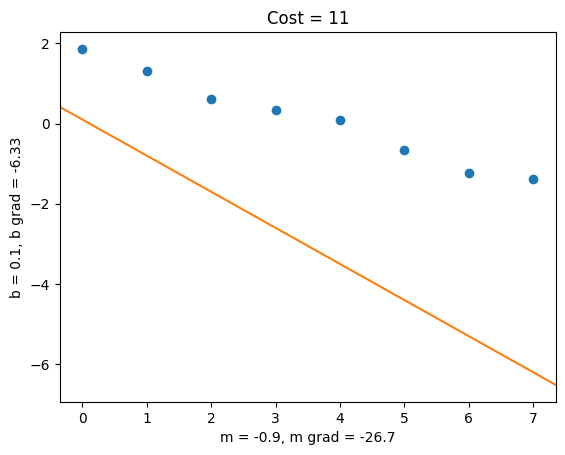

In [42]:
labeled_regression_plot(xs, ys, m, b, C)

**Step 4**: Gradient descent

In the first round of training, with $\frac{\partial C}{\partial m} = 36.3$ and $\frac{\partial C}{\partial b} = 6.26$, the lowest hanging fruit with respect to reducing cost $C$ is to decrease the slope of the regression line, $m$. The model would also benefit from a comparatively small decrease in the $y$-intercept of the line, $b$.

To control exactly how much we adjust the model parameters $\boldsymbol{\theta}$, we set a **learning rate**, a hyperparameter of ML models that use gradient descent (that is typically denoted with $\alpha$):

In [43]:
lr = 0.01 # Cover rules of thumb

We use the learning rate $\alpha$ to scale the gradient, i.e., $\alpha \nabla C$:

In [44]:
scaled_gradient = lr * gradient
scaled_gradient

tensor([[-0.0633],
        [-0.2669]])

We can now use our scaled gradient to adjust our model parameters $\boldsymbol{\theta}$ in directions that will reduce the model cost $C$.

Since, e.g., $\frac{\partial C}{\partial m} = 36.3$ indicates that increasing the slope parameter $m$ corresponds to an increase in cost $C$, we *subtract* the gradient to adjust each individual parameter in a direction that reduces cost: $$ \boldsymbol{\theta}' = \boldsymbol{\theta} - \alpha \nabla C$$

In [45]:
new_theta = theta - scaled_gradient
new_theta

tensor([[ 0.1633],
        [-0.6330]])

To see these adjustments even more clearly, you can consider each parameter individually, e.g., $m' = m - \alpha \frac{\partial C}{\partial m}$:

In [46]:
m - lr*m.grad

tensor([-0.6330], grad_fn=<SubBackward0>)

...and $b' = b - \alpha \frac{\partial C}{\partial b}$:

In [47]:
b - lr*b.grad

tensor([0.1633], grad_fn=<SubBackward0>)

With our updated parameters $\boldsymbol{\theta}$ now in hand, we can use them to check that they do indeed correspond to a decreased cost $C$:

In [48]:
b = new_theta[0]
m = new_theta[1]

In [49]:
C = mse(regression(xs, m, b), ys)

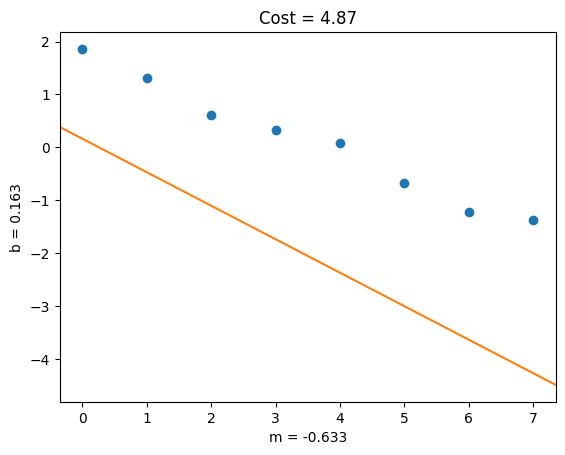

In [50]:
labeled_regression_plot(xs, ys, m, b, C, include_grad=False) # Gradient of C hasn't been recalculated

### Rinse and Repeat

To perform another round of gradient descent, we let PyTorch know we'd like to track gradients on the tensors `b` and `m` (as we did at the top of the notebook when we created them the first time):

In [ ]:
b.requires_grad_()
_ = m.requires_grad_() # "_ =)" is to prevent output within Jupyter; it is cosmetic only

In [ ]:
epochs = 8
for epoch in range(epochs):

    yhats = regression(xs, m, b) # Step 1
    C = mse(yhats, ys) # Step 2

    C.backward() # Step 3

    labeled_regression_plot(xs, ys, m, b, C)

    gradient = torch.tensor([[b.grad.item(), m.grad.item()]]).T
    theta = torch.tensor([[b, m]]).T

    new_theta = theta - lr*gradient # Step 4

    b = new_theta[0].requires_grad_()
    m = new_theta[1].requires_grad_()

(Note that the above plots are identical to those in the [*Batch Regression Gradient* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/batch-regression-gradient.ipynb), in which we used the PyTorch `SGD()` method to descend the gradient.)

In later rounds of training, after the model's slope $m$ has become closer to the slope represented by the data, $\frac{\partial C}{\partial b}$ becomes negative, indicating an inverse relationship between $b$ and $C$. Meanwhile, $\frac{\partial C}{\partial m}$ remains positive.

This combination directs gradient descent to simultaneously adjust the $y$-intercept $b$ upwards and the slope $m$ downwards in order to reduce cost $C$ and, ultimately, fit the regression line snugly to the data.

Finally, let's run a thousand more epochs (without plots) to converge on optimal parameters $\boldsymbol{\theta}$:

In [ ]:
epochs = 992 # accounts for rounds above to match 1000 epochs of regression-in-pytorch.ipynb
for epoch in range(epochs):

    yhats = regression(xs, m, b) # Step 1
    C = mse(yhats, ys) # Step 2

    C.backward() # Step 3

    print('Epoch {}, cost {}, m grad {}, b grad {}'.format(epoch, '%.3g' % C.item(), '%.3g' % m.grad.item(), '%.3g' % b.grad.item()))

    gradient = torch.tensor([[b.grad.item(), m.grad.item()]]).T
    theta = torch.tensor([[b, m]]).T

    new_theta = theta - lr*gradient # Step 4

    b = new_theta[0].requires_grad_()
    m = new_theta[1].requires_grad_()

In [ ]:
labeled_regression_plot(xs, ys, m, b, C, include_grad=False)

(Note that the above results are identical to those in the [*Regression in PyTorch* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/regression-in-pytorch.ipynb), in which we also used the PyTorch `SGD()` method to descend the gradient.)

**Neural network**

In [1]:
import numpy as np
import torch
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Learning rate
alphas = [0.001,0.01,0.1,1,10,100,1000]

In [3]:
# compute sigmoid nonlinearity
def sigmoid(x):
    output = 1/(1+np.exp(-x))
    return output

In [4]:
# convert output of sigmoid function to its derivative
def sigmoid_output_to_derivative(output):
    return output*(1-output)

In [5]:
# Set up X (features) and y (label)
X = np.array([[0,0,1],
            [0,1,1],
            [1,0,1],
            [1,1,1]])

y = np.array([[0],
			[1],
			[1],
			[0]])


In [6]:
X.shape

(4, 3)

In [25]:
# optimization

j_range =40000
disp_dim ={}

# captures tensor shape
disp_dim['X'] = X.shape
disp_dim['y'] = y.shape

for alpha in alphas[0:1]:
    print ("\nTraining With Alpha:" + str(alpha))
    np.random.seed(1)

    # randomly initialize our weights with mean 0
    synapse_0 = 2*np.random.random((3,4)) - 1
    synapse_1 = 2*np.random.random((4,1)) - 1

    # captures tensor shape
    disp_dim['synapse_0'] = synapse_0.shape
    disp_dim['synapse_1'] = synapse_1.shape

    prev_synapse_0_weight_update = np.zeros_like(synapse_0)
    prev_synapse_1_weight_update = np.zeros_like(synapse_1)

    synapse_0_direction_count = np.zeros_like(synapse_0)
    synapse_1_direction_count = np.zeros_like(synapse_1)

    for j in range(j_range):

        # Feed forward through layers 0, 1, and 2
        layer_0 = X
        layer_1 = sigmoid(np.dot(layer_0,synapse_0))
        layer_2 = sigmoid(np.dot(layer_1,synapse_1))

        # captures tensor shape
        disp_dim['layer_1'] = layer_1.shape
        disp_dim['layer_2'] = layer_2.shape

        # how much did we miss the target value?
        layer_2_error = layer_2 - y

        if (j% 10000) == 0:
            print ("Error:" + str(np.mean(np.abs(layer_2_error))))

        # in what direction is the target value?
        # were we really sure? if so, don't change too much.
        layer_2_delta = layer_2_error*sigmoid_output_to_derivative(layer_2)

        # how much did each l1 value contribute to the l2 error (according to the weights)?
        # reuslting matrix shape is (4,4)
        layer_1_error = layer_2_delta.dot(synapse_1.T)

        # captures tensor shape
        disp_dim['layer_1_error'] = layer_1_error.shape
        disp_dim['layer_2_error'] = layer_2_error.shape

        # in what direction is the target l1?
        # were we really sure? if so, don't change too much.
        layer_1_delta = layer_1_error * sigmoid_output_to_derivative(layer_1)

        # captures tensor shape
        disp_dim['layer_1_delta'] = layer_1_delta.shape
        disp_dim['layer_2_delta'] = layer_2_delta.shape

        synapse_1_weight_update = (layer_1.T.dot(layer_2_delta))
        synapse_0_weight_update = (layer_0.T.dot(layer_1_delta))

        # captures tensor shape
        disp_dim['synapse_0_weight_update'] = synapse_0_weight_update.shape
        disp_dim['synapse_1_weight_update'] = synapse_1_weight_update.shape

        if(j > 0):
            synapse_0_direction_count += np.abs(((synapse_0_weight_update > 0)+0) - ((prev_synapse_0_weight_update > 0) + 0))
            synapse_1_direction_count += np.abs(((synapse_1_weight_update > 0)+0) - ((prev_synapse_1_weight_update > 0) + 0))

        # update synapses
        synapse_1 -= alpha * synapse_1_weight_update
        synapse_0 -= alpha * synapse_0_weight_update

        prev_synapse_0_weight_update = synapse_0_weight_update
        prev_synapse_1_weight_update = synapse_1_weight_update

    print ("Synapse 0: ", synapse_0)

    print ("Synapse 0 Update Direction Changes: ", synapse_0_direction_count)

    print ("Synapse 1: ",synapse_1)

    print ("Synapse 1 Update Direction Changes: ",synapse_1_direction_count)

    for i, desc in enumerate(disp_dim.items()):
      print(i, desc)
      # if i % 2 == 0:
      #   print(chr(10))


Training With Alpha:0.001
Error:0.4964100319027255
Error:0.49516402549338606
Error:0.4935960431880486
Error:0.4916063585594306
Synapse 0:  [[-0.24238232  0.34082929 -1.29890944 -0.44390356]
 [-0.73747457 -0.9595718  -1.14141402 -0.31617357]
 [-0.23485547 -0.07325216 -0.29000885  0.3875482 ]]
Synapse 0 Update Direction Changes:  [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 1.]]
Synapse 1:  [[-0.62177634]
 [ 0.73195682]
 [-1.2380943 ]
 [ 0.36775593]]
Synapse 1 Update Direction Changes:  [[0.]
 [1.]
 [0.]
 [1.]]
0 ('X', (4, 3))
1 ('y', (4, 1))
2 ('synapse_0', (3, 4))
3 ('synapse_1', (4, 1))
4 ('layer_1', (4, 4))
5 ('layer_2', (4, 1))
6 ('layer_1_error', (4, 4))
7 ('layer_2_error', (4, 1))
8 ('layer_1_delta', (4, 4))
9 ('layer_2_delta', (4, 1))
10 ('synapse_0_weight_update', (3, 4))
11 ('synapse_1_weight_update', (4, 1))


**Generator code concept**

In [2]:
def is_palindrome(num):
    # Skip single-digit inputs
    if num // 10 == 0:
        return False
    temp = num
    reversed_num = 0

    while temp != 0:
        reversed_num = (reversed_num * 10) + (temp % 10)
        temp = temp // 10

    if num == reversed_num:
        return True
    else:
        return False

In [3]:
def infinite_palindromes():
    num = 0
    while True:
        if is_palindrome(num):
            i = (yield num)
            if i is not None:
                num = i
        num += 1

In [4]:
pal_gen = infinite_palindromes()
for i in pal_gen:

    digits = len(str(i))
    print(i, digits)
    pal_gen.send(10 ** (digits))

11 2
111 3
1111 4
10101 5
101101 6
1001001 7
10011001 8
100010001 9
1000110001 10
10000100001 11
100001100001 12
1000001000001 13


KeyboardInterrupt: 

**Train error vs Test error**

In [16]:
import numpy as np

from sklearn import linear_model
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [14]:
# Generate sample data
n_samples_train, n_samples_test, n_features = 75, 150, 500
X, y, coef = make_regression(
    n_samples=n_samples_train + n_samples_test,
    n_features=n_features,
    n_informative=50,
    shuffle=False,
    noise=1.0,
    coef=True,
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=n_samples_train, test_size=n_samples_test, shuffle=False
)

In [15]:
# Compute train and test errors
alphas = np.logspace(-5, 1, 60)
enet = linear_model.ElasticNet(l1_ratio=0.7, max_iter=10000)
train_errors = list()
test_errors = list()
for alpha in alphas:
    enet.set_params(alpha=alpha)
    enet.fit(X_train, y_train)
    train_errors.append(enet.score(X_train, y_train))
    test_errors.append(enet.score(X_test, y_test))

i_alpha_optim = np.argmax(test_errors)
alpha_optim = alphas[i_alpha_optim]
print("Optimal regularization parameter : %s" % alpha_optim)

# Estimate the coef_ on full data with optimal regularization parameter
enet.set_params(alpha=alpha_optim)
coef_ = enet.fit(X, y).coef_

Optimal regularization parameter : 0.00026529484644318975


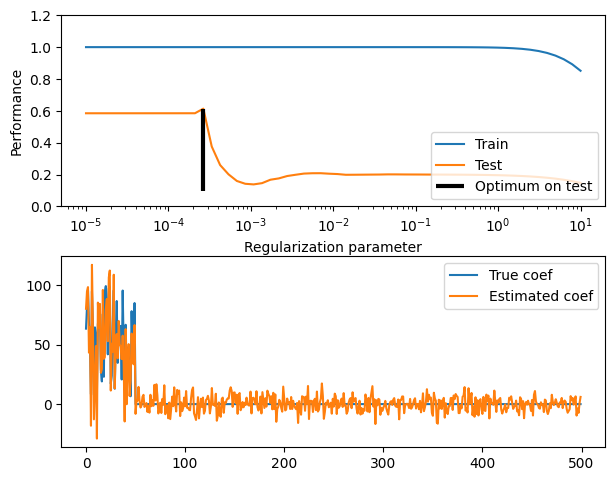

In [17]:
# Plot results functions
plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_errors, label="Train")
plt.semilogx(alphas, test_errors, label="Test")
plt.vlines(
    alpha_optim,
    plt.ylim()[0],
    np.max(test_errors),
    color="k",
    linewidth=3,
    label="Optimum on test",
)
plt.legend(loc="lower right")
plt.ylim([0, 1.2])
plt.xlabel("Regularization parameter")
plt.ylabel("Performance")

# Show estimated coef_ vs true coef
plt.subplot(2, 1, 2)
plt.plot(coef, label="True coef")
plt.plot(coef_, label="Estimated coef")
plt.legend()
plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.26)
plt.show()